<a href="https://colab.research.google.com/github/JacksonLeb/tensorflow_learning/blob/main/06_transfer_learning_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Scaling Up to 101 Image Classes from Food101

In [6]:
#Check to see if we're using a GPU
!nvidia-smi

Tue Jul 19 00:09:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##Creating helper functions

In [7]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-07-19 00:09:59--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-07-19 00:09:59 (100 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [8]:
#importing helper functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

##101 food classes: working with less data

In [9]:
#downloading data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

--2022-07-19 00:10:02--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.115.128, 172.253.122.128, 142.250.73.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.115.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  76.4MB/s    in 21s     

2022-07-19 00:10:23 (75.5 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [10]:
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [11]:
#how many image classses are there
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/panna_cotta'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/french_toast'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/guacamole'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/samosa'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/pad_thai'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/breakfast_burrito'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/pancakes'.
There are 0 directories and 250 images in '101_food

In [12]:
#setup data inputs
import tensorflow as tf
IMG_SIZE = (244, 244)


train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE,
                                                                shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


#training our big model on 10 percent of food 101

In [13]:
#create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_best_only=True,
                                                         monitor="val_accuracy",
                                                         save_weights_only=True)

In [14]:
#Create data augmentation layer to incorprorate right into model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential


#set up data aug
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2),
  #preprocessing.Rescale(1/255.) dont need to, already rescaled in efficient net
], name="data_augmentation")

In [15]:
#set up base model and freeze all base model layers (to start)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

#set up model architecture with trainable top layers
inputs = layers.Input(shape=(244,244,3), name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False) #weights in base model stay frozen
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

16719872/16705208 [==============================] - 0s 0us/step


In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 244, 244, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 244, 244, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool_layer (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [17]:
#compile 
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

#fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5,
                                           steps_per_epoch=len(train_data_all_10_percent),
                                           validation_data=test_data,
                                           validation_steps=int(0.15*len(test_data)),
                                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 112s 401ms/step - loss: 3.4473 - accuracy: 0.2511 - val_loss: 2.5635 - val_accuracy: 0.4439
Epoch 2/5
237/237 [==============================] - 78s 329ms/step - loss: 2.3228 - accuracy: 0.4729 - val_loss: 2.1549 - val_accuracy: 0.4833
Epoch 3/5
237/237 [==============================] - 71s 298ms/step - loss: 1.9551 - accuracy: 0.5368 - val_loss: 1.9816 - val_accuracy: 0.4997
Epoch 4/5
237/237 [==============================] - 64s 271ms/step - loss: 1.7385 - accuracy: 0.5782 - val_loss: 1.8946 - val_accuracy: 0.5114
Epoch 5/5
237/237 [==============================] - 61s 257ms/step - loss: 1.5788 - accuracy: 0.6137 - val_loss: 1.8389 - val_accuracy: 0.5177


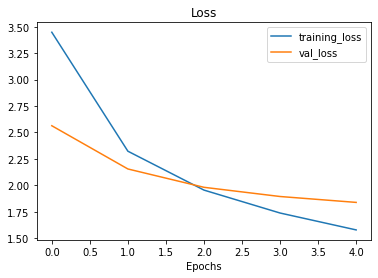

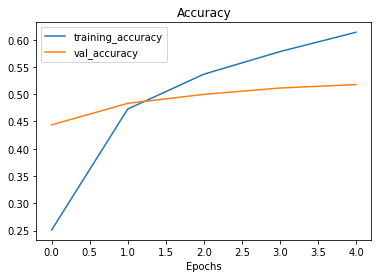

In [18]:
plot_loss_curves(history_all_classes_10_percent)

##fine Tuning

In [19]:
base_model.trainable = True

for layer in base_model.layers[:-5]:
  layer.trainable = False

In [20]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [21]:
#recompile model with lower learning rate
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              metrics=["accuracy"])


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [22]:
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [23]:
for layer in model.layers[2].layers:
  print(layer.name, layer.trainable)

input_1 False
rescaling False
normalization False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_reshape False
block2b_se_reduce False
block2b_se_expand False
block2b_se_excite False
block2b_project_conv False
blo

In [24]:
fine_tune_epochs = 10 #total num of epochs = initial + fine tuning

#fine tuning our model
history_all_classes_10_percent_fine_tuning = model.fit(train_data_all_10_percent,
                                                       epochs=fine_tune_epochs,
                                                       validation_data=test_data,
                                                       validation_steps=int(0.15 * len(test_data)),
                                                       initial_epoch = history_all_classes_10_percent.epoch[-1],)


Epoch 5/10
237/237 [==============================] - 68s 251ms/step - loss: 1.3150 - accuracy: 0.6620 - val_loss: 1.7762 - val_accuracy: 0.5307
Epoch 6/10
237/237 [==============================] - 53s 223ms/step - loss: 1.1966 - accuracy: 0.6828 - val_loss: 1.7924 - val_accuracy: 0.5278
Epoch 7/10
237/237 [==============================] - 52s 218ms/step - loss: 1.1175 - accuracy: 0.7024 - val_loss: 1.7816 - val_accuracy: 0.5331
Epoch 8/10
237/237 [==============================] - 49s 206ms/step - loss: 1.0515 - accuracy: 0.7192 - val_loss: 1.7870 - val_accuracy: 0.5344
Epoch 9/10
237/237 [==============================] - 50s 211ms/step - loss: 0.9884 - accuracy: 0.7402 - val_loss: 1.8077 - val_accuracy: 0.5307
Epoch 10/10
237/237 [==============================] - 49s 205ms/step - loss: 0.9341 - accuracy: 0.7506 - val_loss: 1.7811 - val_accuracy: 0.5416


In [25]:
#Evaluate on the whole test data
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 65s 82ms/step - loss: 1.5357 - accuracy: 0.5982


[1.5357365608215332, 0.5981782078742981]

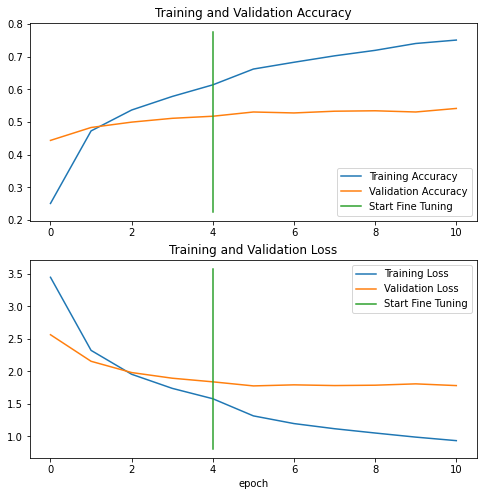

In [26]:
#compare historys
compare_historys(original_history = history_all_classes_10_percent,
                 new_history = history_all_classes_10_percent_fine_tuning)

In [27]:
#Saving and Loading our trained model
model.save("101_food_classes_10_percent_saved_big_model_fine_tuned")

INFO:tensorflow:Assets written to: 101_food_classes_10_percent_saved_big_model_fine_tuned/assets


In [28]:
load_model = tf.keras.models.load_model("101_food_classes_10_percent_saved_big_model_fine_tuned")

In [29]:
loaded_models_results = load_model.evaluate(test_data)
loaded_models_results
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 68s 84ms/step - loss: 1.5357 - accuracy: 0.5982


[1.5357365608215332, 0.5981782078742981]

#making predictions iwth trained model

In [30]:
pred_probs = model.predict(test_data, verbose=1) # set verbosity to see how long is left

790/790 [==============================] - 68s 84ms/step


In [31]:
len(test_data)

790

In [32]:
len(pred_probs)

25250

In [33]:
#Shape of predicitions
pred_probs.shape

(25250, 101)

In [34]:
#first 10 predictions
pred_probs[:10]

array([[5.1949257e-01, 2.3617495e-04, 1.0084990e-01, ..., 3.1902251e-05,
        1.9252073e-03, 8.2009032e-02],
       [8.5284227e-01, 2.6353158e-07, 3.8120497e-03, ..., 3.0699363e-03,
        2.2435876e-07, 9.6513086e-06],
       [4.7951344e-01, 4.1812691e-03, 1.4088176e-02, ..., 8.1285584e-04,
        4.0331142e-04, 3.5000111e-03],
       ...,
       [2.7570090e-01, 8.4702360e-06, 3.9883764e-03, ..., 8.3762608e-02,
        3.7141697e-04, 2.2983573e-05],
       [4.3541335e-02, 4.8517832e-04, 7.3077656e-02, ..., 5.5768560e-05,
        1.3336247e-04, 3.6257660e-04],
       [2.0416024e-01, 2.3357602e-06, 7.9465623e-04, ..., 4.2495236e-02,
        5.1041638e-06, 4.5285122e-03]], dtype=float32)

In [35]:
#first predicition
pred_probs[0]

array([5.1949257e-01, 2.3617495e-04, 1.0084990e-01, 1.5227464e-08,
       1.6757072e-05, 7.5603089e-07, 2.2405529e-04, 6.4886326e-06,
       1.7122259e-02, 1.7013503e-04, 7.4869081e-07, 6.3579992e-06,
       1.8923922e-03, 7.9545202e-08, 3.7979109e-03, 2.6284577e-04,
       5.3370477e-06, 6.1759254e-04, 1.6241196e-03, 2.7938097e-06,
       8.5064705e-05, 9.9741510e-06, 7.6065138e-05, 1.5564389e-04,
       1.6034859e-03, 5.0607004e-04, 2.9923581e-04, 1.3518236e-05,
       4.0890351e-02, 8.5288181e-04, 1.9206830e-06, 6.6054414e-04,
       5.4625102e-04, 2.5146434e-08, 1.3256310e-02, 2.0728447e-05,
       1.4599202e-05, 8.9129288e-04, 2.0691387e-02, 5.0576746e-05,
       1.3070181e-04, 5.9677969e-04, 5.2491510e-03, 7.2784616e-07,
       2.1438593e-05, 9.4967654e-06, 9.7192638e-04, 8.7179686e-04,
       2.5926573e-07, 2.3823796e-02, 8.8786712e-04, 2.8263166e-06,
       5.4274961e-02, 1.1505042e-02, 2.8614941e-05, 3.0051891e-03,
       1.5701018e-02, 1.3416179e-03, 1.2094515e-03, 1.2805824e

In [36]:
len(pred_probs[0])

101

In [37]:
print(f"Number of predicition probabilites for sample 0: {len(pred_probs[0])}")
print(f"What preidcition probability sample 0 looks like: {pred_probs[0]}")
print(f"best predicited probability of sample 0: {pred_probs[0].argmax()}")

Number of predicition probabilites for sample 0: 101
What preidcition probability sample 0 looks like: [5.1949257e-01 2.3617495e-04 1.0084990e-01 1.5227464e-08 1.6757072e-05
 7.5603089e-07 2.2405529e-04 6.4886326e-06 1.7122259e-02 1.7013503e-04
 7.4869081e-07 6.3579992e-06 1.8923922e-03 7.9545202e-08 3.7979109e-03
 2.6284577e-04 5.3370477e-06 6.1759254e-04 1.6241196e-03 2.7938097e-06
 8.5064705e-05 9.9741510e-06 7.6065138e-05 1.5564389e-04 1.6034859e-03
 5.0607004e-04 2.9923581e-04 1.3518236e-05 4.0890351e-02 8.5288181e-04
 1.9206830e-06 6.6054414e-04 5.4625102e-04 2.5146434e-08 1.3256310e-02
 2.0728447e-05 1.4599202e-05 8.9129288e-04 2.0691387e-02 5.0576746e-05
 1.3070181e-04 5.9677969e-04 5.2491510e-03 7.2784616e-07 2.1438593e-05
 9.4967654e-06 9.7192638e-04 8.7179686e-04 2.5926573e-07 2.3823796e-02
 8.8786712e-04 2.8263166e-06 5.4274961e-02 1.1505042e-02 2.8614941e-05
 3.0051891e-03 1.5701018e-02 1.3416179e-03 1.2094515e-03 1.2805824e-04
 7.7537806e-07 1.2327272e-04 1.9461956e-02 2.

In [38]:
test_data.class_names[0]

'apple_pie'

In [39]:
pred_classes = pred_probs.argmax(axis=1)
pred_classes[:10]

array([ 0,  0,  0, 80, 29, 78, 29,  0,  9, 72])

In [40]:
#how many pred classes
len(pred_classes)

25250

#compare predicitions array to original test data labels


In [41]:
#unraveling test_data BatchDataset
y_labels=[]
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

#Evaluating the models predictions

In [42]:
#checking order of pred vs. test data
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true=y_labels,
                                  y_pred=pred_classes)
sklearn_accuracy

0.5981782178217822

In [43]:
import numpy as np
np.isclose(all_classes_10_percent_fine_tune_results, sklearn_accuracy)

array([False,  True])

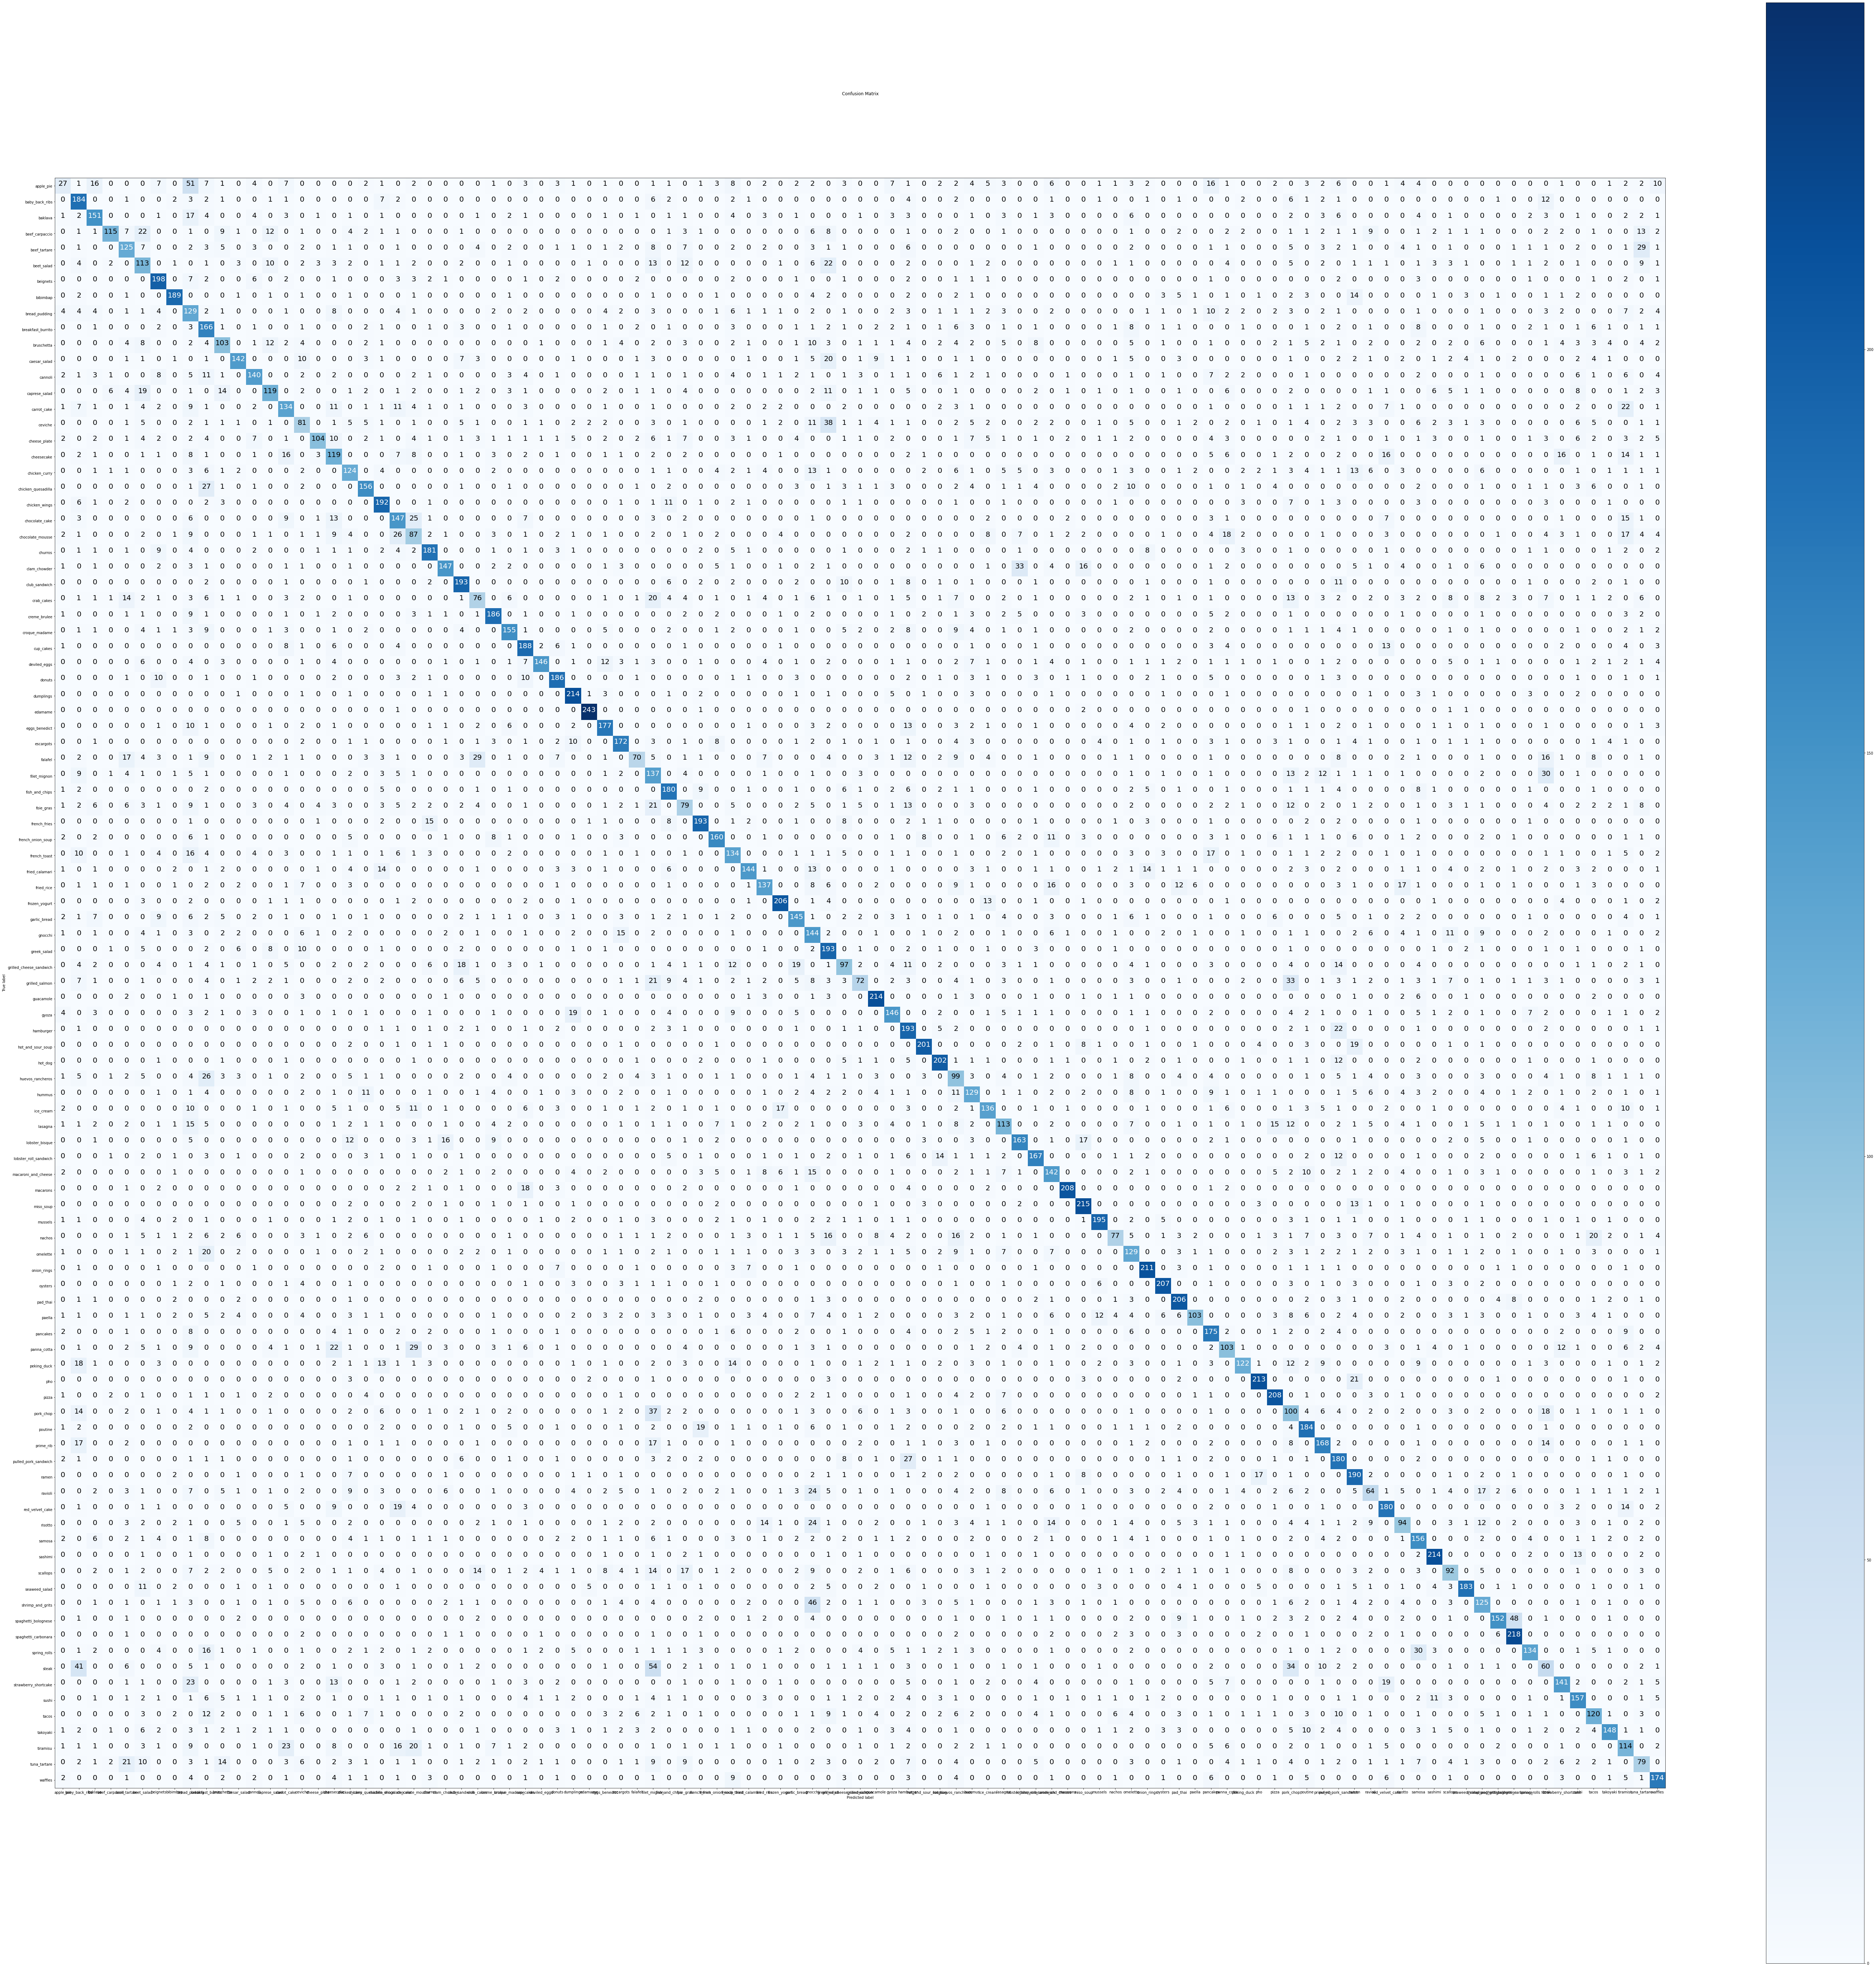

In [48]:
class_names = test_data.class_names
#making a confusion matrix 
#visualizing with helper fucntions
from helper_functions import make_confusion_matrix
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100,100),
                      text_size=20)

#classification reports for other metrics on predictions

In [49]:
#SciKitLearn classification metrics (precision, recall, F1)
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.36      0.11      0.17       250
           1       0.49      0.74      0.59       250
           2       0.65      0.60      0.63       250
           3       0.85      0.46      0.60       250
           4       0.49      0.50      0.50       250
           5       0.39      0.45      0.42       250
           6       0.67      0.79      0.72       250
           7       0.85      0.76      0.80       250
           8       0.27      0.52      0.35       250
           9       0.39      0.66      0.49       250
          10       0.51      0.41      0.46       250
          11       0.73      0.57      0.64       250
          12       0.70      0.56      0.62       250
          13       0.61      0.48      0.54       250
          14       0.53      0.54      0.53       250
          15       0.40      0.32      0.36       250
          16       0.83      0.42      0.55       250
          17       0.43    

In [50]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_true=y_labels,
                            y_pred=pred_classes, output_dict=True)
classification_report_dict

{'0': {'f1-score': 0.16615384615384615,
  'precision': 0.36,
  'recall': 0.108,
  'support': 250},
 '1': {'f1-score': 0.5906902086677367,
  'precision': 0.4932975871313673,
  'recall': 0.736,
  'support': 250},
 '10': {'f1-score': 0.4567627494456763,
  'precision': 0.5124378109452736,
  'recall': 0.412,
  'support': 250},
 '100': {'f1-score': 0.6603415559772297,
  'precision': 0.628158844765343,
  'recall': 0.696,
  'support': 250},
 '11': {'f1-score': 0.6382022471910112,
  'precision': 0.7282051282051282,
  'recall': 0.568,
  'support': 250},
 '12': {'f1-score': 0.6236080178173721,
  'precision': 0.7035175879396985,
  'recall': 0.56,
  'support': 250},
 '13': {'f1-score': 0.5360360360360361,
  'precision': 0.6134020618556701,
  'recall': 0.476,
  'support': 250},
 '14': {'f1-score': 0.532803180914513,
  'precision': 0.5296442687747036,
  'recall': 0.536,
  'support': 250},
 '15': {'f1-score': 0.35682819383259917,
  'precision': 0.39705882352941174,
  'recall': 0.324,
  'support': 250}

In [51]:
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [52]:
class_names[70]

'pad_thai'

In [54]:
#create empty dictionary
class_f1_scores = {}
for k, v in classification_report_dict.items():
  if k == "accuracy":
    break
  else:
    class_f1_scores[class_names[int(k)]] = v["f1-score"]

In [55]:
class_f1_scores

{'apple_pie': 0.16615384615384615,
 'baby_back_ribs': 0.5906902086677367,
 'baklava': 0.6265560165975104,
 'beef_carpaccio': 0.5974025974025975,
 'beef_tartare': 0.495049504950495,
 'beet_salad': 0.4192949907235622,
 'beignets': 0.7239488117001828,
 'bibimbap': 0.8008474576271186,
 'bread_pudding': 0.3519781718963166,
 'breakfast_burrito': 0.494047619047619,
 'bruschetta': 0.4567627494456763,
 'caesar_salad': 0.6382022471910112,
 'cannoli': 0.6236080178173721,
 'caprese_salad': 0.5360360360360361,
 'carrot_cake': 0.532803180914513,
 'ceviche': 0.35682819383259917,
 'cheese_plate': 0.5531914893617021,
 'cheesecake': 0.45075757575757575,
 'chicken_curry': 0.5,
 'chicken_quesadilla': 0.6513569937369521,
 'chicken_wings': 0.7045871559633027,
 'chocolate_cake': 0.5464684014869888,
 'chocolate_mousse': 0.3565573770491803,
 'churros': 0.7327935222672065,
 'clam_chowder': 0.6621621621621621,
 'club_sandwich': 0.7269303201506592,
 'crab_cakes': 0.36363636363636365,
 'creme_brulee': 0.7425149700

In [58]:
#Turning f1 scores into a dataframe
import pandas as pd
f1_scores = pd.DataFrame({"class_names":list(class_f1_scores.keys()),
                         "f1-score": list(class_f1_scores.values())}).sort_values("f1-score",ascending=False)

In [59]:
f1_scores

,class_names,f1-score
33,edamame,0.960474
63,macarons,0.883227
75,pho,0.846918
86,sashimi,0.829457
54,hot_and_sour_soup,0.825462
...,...,...
99,tuna_tartare,0.341991
77,pork_chop,0.321543
82,ravioli,0.312195
93,steak,0.256959


In [61]:
f1_scores[:10]

,class_names,f1-score
33,edamame,0.960474
63,macarons,0.883227
75,pho,0.846918
86,sashimi,0.829457
54,hot_and_sour_soup,0.825462
69,oysters,0.824701
45,frozen_yogurt,0.820717
68,onion_rings,0.817829
51,guacamole,0.815238
65,mussels,0.807453


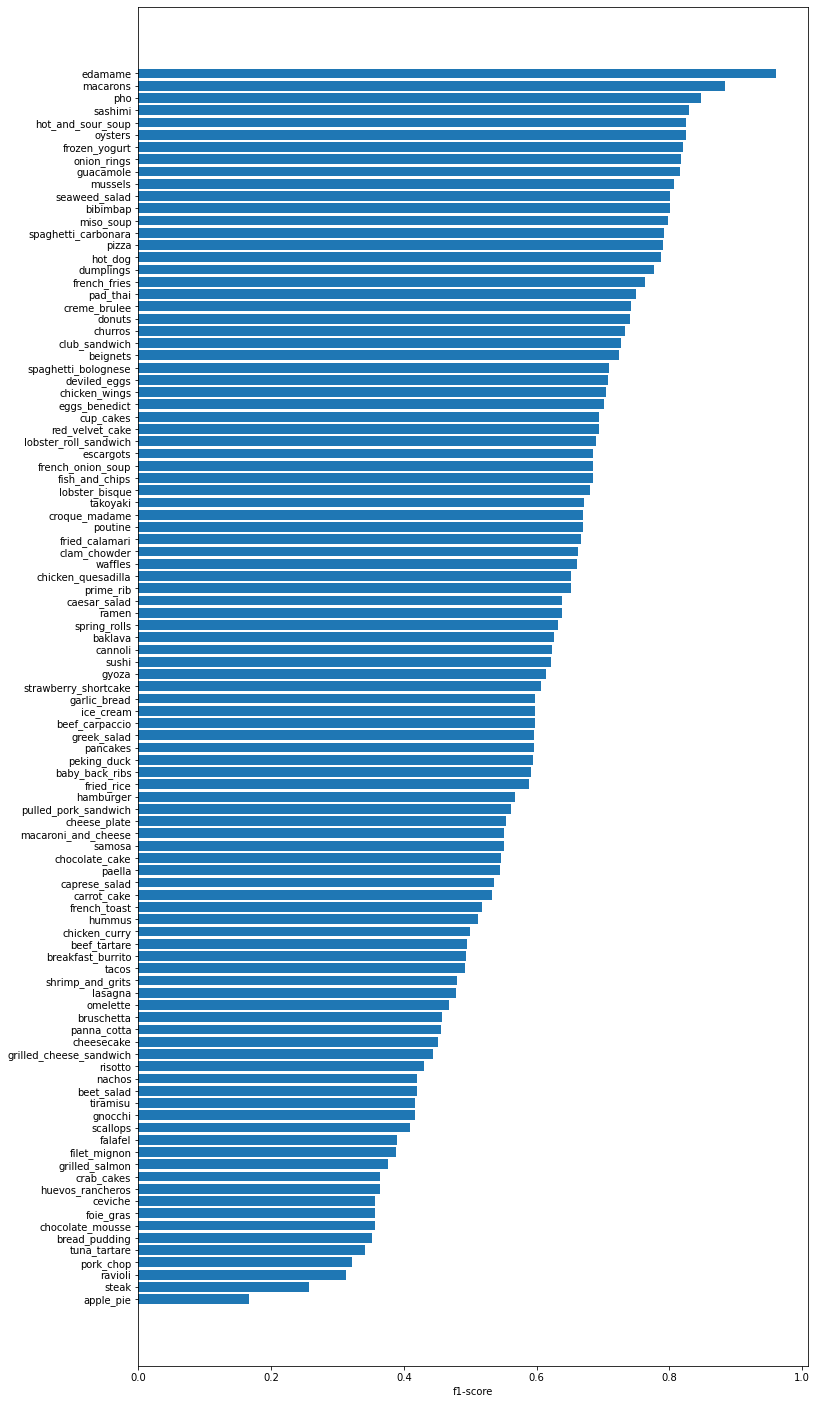

In [66]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("f1-score")
ax.invert_yaxis()


In [67]:
#creating a function to load and prepare imagres
def load_and_prep_image(filename, img_shape=244, scale=True):
  """
  Reads in file anmea nd preps image
  """
  #rading in image
  img = tf.io.read_file(filename)

  #decodee imag ein to tensor
  img = tf.io.decode_image(img, channels=3)

  #resize
  img = tf.image.resize(img, [img_shape, img_shape])

  #scale
  if(scale):
    #rescale
    return img/255.
  else:
    return img